# Overview

Finance and algorithmic trading heavily use linear algebra.  In this project, we will investigate how you can directly create a portfolio (set of allocations for companies in the market) by using the singular value decomposition (SVD) that you learned in class.  In essence, we will use the past daily prices for over 1000 companies over a "training" period to generate right singular vectors and normalize these singular vectors to get allocations for each of the 1000 companies over the "test" period.

In particular, we outline below how to create these "eigen"-portfolios:
1. Import necessary packages and data.
2. Pre-process, clean up, and plot the data using pandas and matplotlib.
3. Transform the data to use company returns and normalized returns rather than close prices.
4. Split the data into a training set and a test set.
5. Compute the SVD of the training data (you will complete this portion).
6. Plot the SVD to get a sense of the market.
7. Compile the SVD into the eigen-portfolios.
8. Compute returns and cumulative returns.
9. Compute performances of portfolios with the Sharpe ratio.
10. Plot performances of best eigen-portfolios.

The only aspects of these steps that you need to actually do here will be to compute the SVD and compile the SVD into the eigen-portfolios.


In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

df_path = 'close_prices.csv'

ModuleNotFoundError: No module named 'pandas'

# Uploading data into Google Colaboratory

To actually run this jupyter notebook, you can run jupyter notebook on your own computer if you have it set up; however, you may also use Google colaboratory to create and run this notebook.  I've implemented the first method of how to import the data into google colaboratory.  The details are outlined [here](https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8).  If you are using Google colaboratory, uncomment the lines of code after the first in the next cell.

In [ ]:
# only uncomment the next lines if using google colaboratory (takes some time)
# import io
# from google.colab import files
# uploaded = files.upload()
# df_path = io.StringIO(uploaded['close_prices.csv']).decode('utf-8')

# Data Wrangling

We clean the data here to make sure that any of the dates we use have at least 500 data points.  In particular, we get rid of dates that have too many `NaN` values.  We also transform the dates into pandas datetime indices to be able to easily manage data.  We finally take a look at some portion of the dataframe.

In [ ]:
# import data
close_prices = pd.read_csv(df_path)
# clean data
close_prices['date'] = close_prices['date'].apply(lambda x: x.split()[0])
close_prices = close_prices.set_index(['date'])
close_prices = close_prices[~close_prices.index.duplicated(keep='first')]
close_prices = close_prices[close_prices.isnull().sum(axis=1) < 500]
dts = pd.to_datetime(close_prices.index)
close_prices.index = dts
close_prices.name = 'prices'
close_prices.head(40)

,AAIC,AAL,AAON,AAP,AAPL,AB,ABB,ABBV,ABC,ABCB,...,Y,YELL,YNDX,YPF,YUM,ZBH,ZBRA,ZD,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1999-11-01,17.215847,NaN,0.963988,NaN,0.595872,5.832890,NaN,NaN,2.646925,5.628370,...,150.909670,108830.902945,NaN,11.167411,4.896850,NaN,11.712591,2.698182,40.477164,NaN
1999-11-02,18.253337,NaN,0.995558,NaN,0.616062,6.378645,NaN,NaN,2.621790,5.602393,...,151.699773,108438.483824,NaN,11.073691,4.821997,NaN,11.341362,2.541675,41.676538,NaN
1999-11-03,18.026386,NaN,1.009507,NaN,0.625658,6.289377,NaN,NaN,2.536717,5.576416,...,151.897299,110400.579430,NaN,11.020973,4.738693,NaN,11.142843,2.541675,41.162521,NaN
1999-11-04,18.447866,NaN,0.995558,NaN,0.641933,6.555154,NaN,NaN,2.513515,5.576416,...,150.909670,110008.160309,NaN,10.927252,4.738693,NaN,10.918517,2.579237,41.553174,NaN
1999-11-05,19.452934,NaN,1.005102,NaN,0.677937,6.620076,NaN,NaN,2.440043,5.576416,...,149.724516,109223.322067,NaN,10.836460,4.882363,NaN,10.906606,2.623059,42.622331,NaN
1999-11-08,18.836925,NaN,0.991153,NaN,0.739812,6.441539,NaN,NaN,2.453578,5.736608,...,149.724516,107195.823274,NaN,10.836460,4.896850,NaN,11.426725,2.660621,43.136348,NaN
1999-11-09,18.447866,NaN,0.963988,NaN,0.687993,6.429366,NaN,NaN,2.513515,5.628370,...,149.329464,107588.242395,NaN,10.982899,5.026033,NaN,11.426725,4.206911,42.492113,NaN
1999-11-10,17.831857,NaN,0.945633,NaN,0.701965,6.327925,NaN,NaN,2.610189,5.576416,...,147.354207,110400.579430,NaN,11.129337,5.259044,NaN,11.662962,4.307075,42.492113,NaN
1999-11-11,17.831857,NaN,0.940494,NaN,0.708183,6.175762,NaN,NaN,2.501915,5.602393,...,146.666817,111185.417673,NaN,11.038545,5.335104,NaN,11.762221,4.188130,42.409870,NaN


# Plotting functionality

Just to get a visual idea of the data, we plot the prices for a particular symbol.  We will finally plot this for the asset returns later on as well.  Take a look at the plot for `AAPL`.

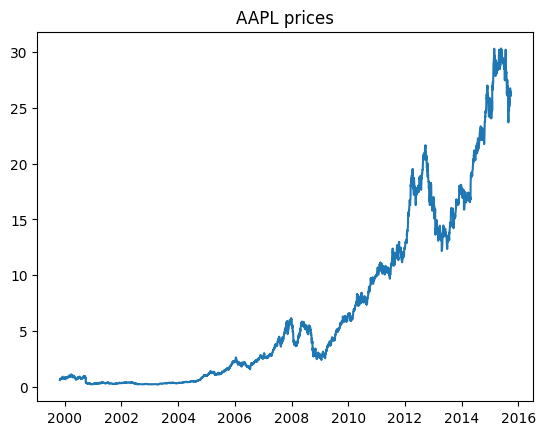

In [ ]:
# plotting function
def plot_symbol(symbol, df, csum=False):
    # csum denotes cummulative summation (useful for returns)
    yvals = df[symbol]
    if csum: yvals = np.cumsum(yvals)
    plt.plot(df.index, yvals)
    title = symbol + ' ' + df.name
    plt.title(title)

# check price chart for
plot_symbol('AAPL', close_prices)


# Asset Returns Transform

We calculate the returns by the day-to-day percent change of an asset.  Once we have the returns, we normalize them by normalizing each individual asset's mean and standard deviation.  Why would we want to normalize the returns in this manner?

In [ ]:
# calculate the percent change of each asset (pandas as an easy way to do this....)
returns = close_prices.pct_change().dropna(axis=0, how='all')
normed_returns = (returns - returns.mean())/returns.std()
normed_returns = normed_returns.dropna(axis=0, how='all')
returns.name = 'returns'
normed_returns.name = 'normalized returns'

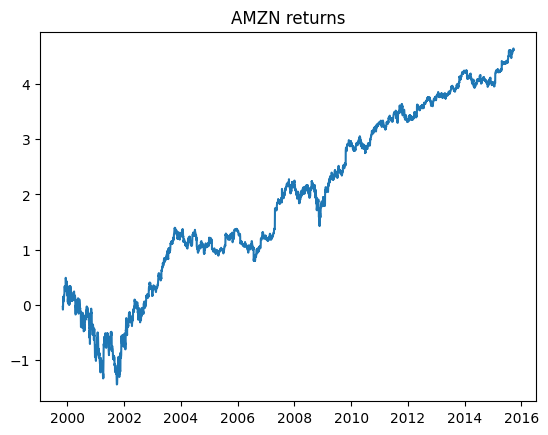

In [ ]:
# plot returns
plot_symbol('AMZN', returns, csum=True)

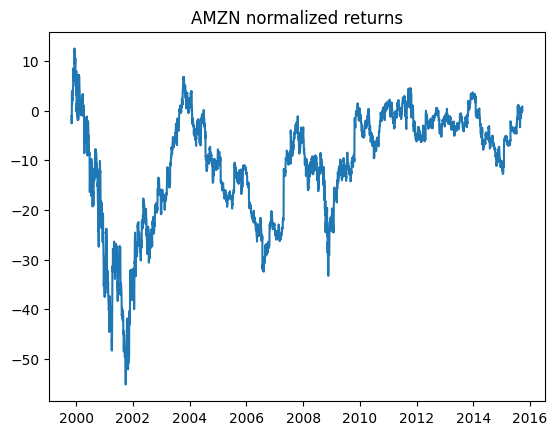

In [ ]:
# plot normalized returns
plot_symbol('AMZN', normed_returns, csum=True)

# Data Preparation

In this section, we create a training and test data set.

In [ ]:
# use datetime cut-off for training vs test data set
train_end = datetime.datetime(2014, 9, 24) 

# get training data for normed returns
df_train = normed_returns[normed_returns.index <= train_end].copy().dropna(axis=1, how='any')
# get test data for normed returns
df_test = normed_returns[normed_returns.index > train_end].copy().dropna(axis=1, how='any')
df_test = df_test[df_train.columns] # retain same tickers in test data as in training

# get training data for regular returns
df_raw_train = returns[returns.index <= train_end].copy().dropna(axis=1, how='any')
# get test data for regular returns
df_raw_test = returns[returns.index > train_end].copy().dropna(axis=1, how='any')
df_raw_test = df_raw_test[df_train.columns] # retain same tickers in test data as in training

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3747, 1073)
Test dataset: (252, 1073)


# Computing SVD of training data

Consider our training data matrix as an $T \times N$ matrix $X$ with $N$ samples (our tickers) and $T$ variables (our dates).  If we assume that $X$ is normalized as we have done above, we can calculate the empirical correlation matrix of our data by
$$C = \frac{1}{T-1} X^\top X \in \mathbb{R}^{N \times N}$$ with eigendecomposition $C = V L V^\top$.  The eigenvectors of $C$ should tell us how the stocks correlate to each other.  Notice, however, that the eigenvectors $V$ of $C$ are just the right singular vectors of $X = U \Sigma V^\top$.  This means that we only need to compute the SVD of our data to be able to investigate the correlation of the stocks.  Let's calculate the SVD using [`numpy`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).  Call the right singular vectors `v` for `df_train` and `v_raw` for `df_raw_train`.

After gathering the singular vectors, we proceed to create a scatter plot of the singular vectors.  Try to plot different singular vectors and comment on the behavior of the singular vectors for the normalized vs raw return SVDs.

In [ ]:
# calculate SVD here
U, s, Vh = np.linalg.svd(df_train, full_matrices=True, compute_uv=True, hermitian=False)
v = Vh
U_raw, s_raw, Vh_raw = np.linalg.svd(df_raw_train, full_matrices=True, compute_uv=True, hermitian=False)
v_raw = Vh_raw


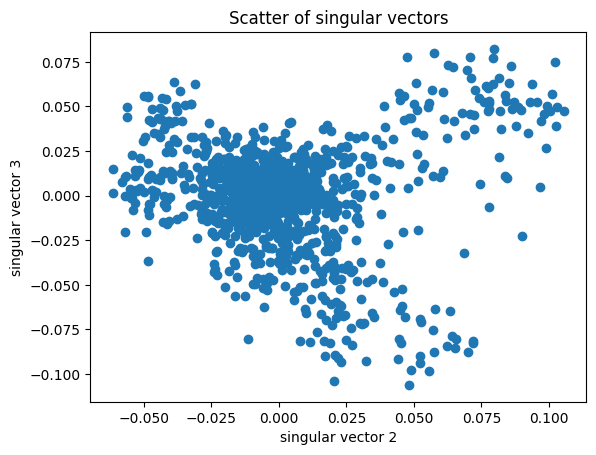

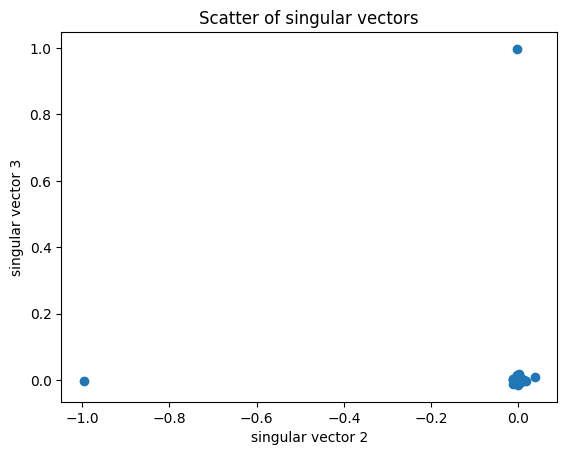

In [ ]:
# plot the 
def scatter_plot_svd(v, i1=1, i2=2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(v[i1,:], v[i2,:])
    title = 'Scatter of singular vectors'
    ax.set_title(title)
    ax.set_xlabel('singular vector '+str(i1))
    ax.set_ylabel('singular vector '+str(i2))
    
scatter_plot_svd(v, 2, 3)
scatter_plot_svd(v_raw, 2, 3)

# Generate portfolios by normalizing

We will define the $j$th eigenportfolio $Q^{(j)}$ by simply the normalized $j$th right singular vector $v^{(j)}$ so that the resultant $Q^{(j)}$ sums to 1.  In particular, compute
$$ Q^{(j)} = \frac{1}{\sum_{k=1}^N v^{(j)}_k } v^{(j)}.$$  We do this in the function below and compile the portfolios into a single pandas dataframe.

In [ ]:
def j_eigPortfolio(s_vecs, tickers=df_train.columns):
    # make empty portfolio list
    portfolios = []
    for j in range(len(tickers)):
        # normalize singular vector to sum to 1
        j_port = s_vecs[:, j] / sum(s_vecs[:, j])  # calculate the jth eigenportfolio
        
        j_port_df = pd.DataFrame(j_port, index=tickers, columns=['Q_' + str(j + 1)])
        portfolios.append(j_port_df)
        
    portfolios = pd.concat(portfolios, axis=1)
    return portfolios

portfolios_svd = j_eigPortfolio(v)  # SVD portfolio computed from normalized returns
portfolios_svd_raw = j_eigPortfolio(v_raw)  # SVD portfolio computed from raw returns


In [ ]:
# view data
display(portfolios_svd_raw.head(10))
display(portfolios_svd.head(10))

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,...,Q_1064,Q_1065,Q_1066,Q_1067,Q_1068,Q_1069,Q_1070,Q_1071,Q_1072,Q_1073
AAIC,0.056827,0.068365,-0.042401,-1.078481e-02,0.275113,-0.038717,1.412767,-0.032425,-0.021597,0.043711,...,-1.361164,0.011456,0.173740,0.067700,0.076117,0.017905,-0.019697,-0.036768,0.900394,-0.085175
AAON,0.001330,0.002022,-0.001514,-4.435148e-04,0.033675,-0.001569,0.064405,-0.002471,-0.000075,0.004081,...,0.291031,0.001373,0.019638,0.002187,0.007473,0.003051,-0.002493,0.004291,-0.099297,-0.006799
AAPL,-0.002579,0.000923,-0.000619,9.327598e-05,-0.022014,0.001781,0.012366,-0.008694,0.000124,0.000755,...,-0.131863,-0.000341,-0.005328,-0.003902,-0.003146,-0.011515,0.004634,-0.002443,-0.030078,0.004784
AB,0.002078,0.007234,-0.003600,-2.574324e-07,-0.014608,-0.000632,-0.066227,0.000790,0.000941,-0.007122,...,-0.059833,0.000451,0.006902,0.007779,0.003889,-0.003568,-0.001021,-0.003862,-0.020276,-0.003442
ABC,-0.017084,-0.023458,-0.063461,3.236318e-03,-0.082182,0.039400,-1.134977,-0.092327,0.006313,0.036444,...,-1.741429,-0.004598,0.061054,-0.078096,-0.041757,-0.000777,0.012830,-0.034290,0.149862,0.098698
ABCB,0.028911,0.035555,0.000542,-4.060025e-03,-0.032001,-0.037893,-2.264233,0.030704,-0.008541,0.010494,...,0.374711,-0.000699,0.048185,0.029037,0.036536,-0.045049,-0.007350,0.002183,-0.084296,-0.114637
ABEV,-0.010244,0.002445,-0.004875,1.940880e-03,0.033777,0.014775,1.072007,-0.002728,0.003048,-0.009236,...,0.413391,-0.000722,0.032408,-0.013150,-0.031243,0.012652,-0.002290,-0.006545,-0.055929,0.034921
ABIO,0.029813,0.019163,0.006019,1.238815e-03,-0.130445,-0.007765,-0.109772,-0.011431,-0.001370,0.009973,...,-0.894327,-0.001726,-0.042602,0.000002,0.003503,0.008517,0.001785,0.006736,-0.232979,-0.018733
ABM,-0.068604,-0.059512,-0.031999,-4.120063e-03,-0.105770,0.037149,0.500544,0.239943,0.010095,-0.070296,...,5.336059,-0.000564,0.110757,-0.027523,0.048666,0.009479,-0.012111,-0.018415,-1.100160,-0.053205
ABMD,0.036986,-0.038508,-0.014295,-5.940227e-03,-0.977669,-0.004607,0.204587,0.074977,0.021773,-0.039275,...,2.136357,-0.020450,0.076373,0.033831,0.117490,-0.002972,0.022086,0.002241,-0.480377,-0.118972


,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,...,Q_1064,Q_1065,Q_1066,Q_1067,Q_1068,Q_1069,Q_1070,Q_1071,Q_1072,Q_1073
AAIC,-0.027821,0.048168,-0.021720,0.028801,0.034427,0.015206,0.042896,0.004025,0.046204,-0.055022,...,-0.570000,0.348739,0.031870,-0.033191,-0.062028,0.009943,-0.025681,0.015892,-0.025522,0.153658
AAON,0.005747,-0.004519,-0.047816,-0.001412,-0.004843,-0.014925,-0.023300,0.013002,-0.000987,-0.062196,...,-0.901382,-0.046092,0.024603,0.039344,0.005465,0.004477,0.009436,0.024921,-0.013874,-0.162655
AAPL,-0.022642,0.029354,-0.003975,0.011849,-0.033543,0.017311,-0.073153,-0.000859,0.017509,-0.024497,...,-0.001937,-0.144697,0.005956,-0.016287,-0.044585,-0.026378,-0.000396,0.000654,-0.003651,0.212691
AB,0.016643,-0.013506,0.004895,-0.007061,0.099029,-0.005280,-0.035265,-0.001965,0.014586,0.007444,...,0.185022,0.422642,-0.007081,0.017616,0.052232,-0.011580,-0.031154,-0.005031,0.002474,-0.079914
ABC,-0.034310,0.060745,-0.006159,-0.025014,0.008549,0.020158,-0.010211,0.006552,0.051147,-0.087447,...,-0.871809,0.054174,-0.017883,0.000379,0.093278,-0.002662,0.023517,0.009412,-0.012799,-0.200876
ABCB,0.018054,0.064446,0.024968,-0.026134,0.006697,0.003220,-0.029971,-0.003335,0.050252,0.022287,...,0.385385,0.118718,-0.006391,0.046343,-0.081716,0.003972,-0.030679,-0.001655,-0.033130,-0.279268
ABEV,0.008980,0.029309,0.018594,0.003973,0.015550,0.010853,-0.051258,0.003503,0.022675,-0.059477,...,-0.832208,0.308330,-0.007672,-0.033530,0.012798,0.023863,0.027187,-0.002708,-0.014569,0.479376
ABIO,-0.012799,0.000425,0.005381,-0.007882,0.103518,-0.002407,0.057372,0.018024,0.007103,-0.082421,...,-1.372040,0.598662,-0.026892,-0.030016,0.114415,-0.015344,-0.016102,-0.007269,-0.012501,-0.154268
ABM,0.016912,-0.010735,0.026510,0.021890,0.086654,-0.010917,-0.025304,0.018890,0.000999,-0.113494,...,-2.710264,0.385105,0.020295,-0.042971,0.015843,0.015749,0.008590,0.004224,0.006792,-0.132248
ABMD,-0.019059,0.004292,-0.023175,-0.024446,0.049187,0.008555,-0.055351,-0.002042,-0.005228,-0.007106,...,-0.125215,0.021783,-0.026423,0.010229,0.036414,-0.010239,-0.021831,-0.006040,-0.015829,-0.024632


# Compute performance of eigenportfolios

## Compute returns and cumulative returns

We will simply compute the dot product of each eigenportfolio weight with how each stock performed for the test data.  This is easily done by using `.dot` for a pandas dataframe.  Afterwards, we can compute the cumulative returns by just using the pandas function `.cumsum()`.  We will consider 3 portfolio performances:
1. How the SVD portfolio from the normalized returns training data behaves against the normalized returns test data.
2. How the SVD portfolio from the raw returns training data behaves against the raw returns test data.
3. How the SVD portfolio from the normalized returns training data behaves against the raw returns test data.

In [ ]:
# use df.dot from pandas to do this
# SVD returns
svd_rets = df_test.dot(portfolios_svd) # norm_return train vs norm_return 
svd_rets_raw = df_raw_test.dot(portfolios_svd_raw) # raw_return train vs raw_return test
svd_rets_prime = df_raw_test.dot(portfolios_svd) # norm_return train vs raw_return test
# SVD cumulative returns
c_svd_rets = svd_rets.cumsum()
c_svd_rets_raw = svd_rets_raw.cumsum()
c_svd_rets_prime = svd_rets_prime.cumsum()

## Performance metrics with Sharpe Ratio

When looking for a good investment, we want **positive steady** returns.  We can think of the **positive** returns aspect as a positive average return whilst the **steady** returns aspect can be thought of as having low variance in the returns.  This idea gives rise to the Sharpe ratio $\frac{\mu}{\sigma}$, a common method to measure the profitability of a trading strategy, which is essentially the mean divided by the standard deviation.  

* A high Sharpe ratio indicates high average returns with low variance (i.e. steady returns).
* A low (but positive) Sharpe ratio means positive returns but risky.
* A negative Sharpe ratio means negative returns.


We will calculate the Sharpe ratios of all the portfolios and order them by the best performing ones.

In [ ]:
# sharpe ratio calculations
def sharpe_ratio(ts_returns):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.
    
    n_years = ts_returns.shape[0]
    ret = ts_returns.mean()
    ret.name = 'mean returns'
    tot_rets = ts_returns.sum()
    tot_rets.name = 'cumulative returns'
    vol = ts_returns.std()
    vol.name = 'vol'
    sharpe = ret / vol
    sharpe.name = 'sharpe'
    out_df = pd.concat([ret, tot_rets ,vol,sharpe],axis=1)
    return out_df


# svd sharpe ratios
svd_sharpe = sharpe_ratio(svd_rets).sort_values(by=['sharpe'], ascending=False)
svd_raw_sharpe = sharpe_ratio(svd_rets_raw).sort_values(by=['sharpe'], ascending=False)
svd_prime_sharpe = sharpe_ratio(svd_rets_prime).sort_values(by=['sharpe'], ascending=False)

Take a look at the top 5 performing portfolios from each section.

In [ ]:
print('SVD sharpe')
display(svd_sharpe.head(5))
print('SVD raw sharpe')
display(svd_raw_sharpe.head(5))
print('SVD prime sharpe')
display(svd_prime_sharpe.head(5))

SVD sharpe


,mean returns,cumulative returns,vol,sharpe
Q_151,2.018960,508.777939,9.290813,0.217307
Q_24,31.950090,8051.422578,161.814945,0.197448
Q_549,0.448045,112.907255,2.517705,0.177958
Q_368,0.810162,204.160903,4.808526,0.168485
Q_450,0.386109,97.299591,2.358730,0.163694


SVD raw sharpe


,mean returns,cumulative returns,vol,sharpe
Q_940,0.009772,2.462480,0.046595,0.209717
Q_430,0.010665,2.687557,0.051755,0.206067
Q_969,0.007135,1.797981,0.036731,0.194246
Q_732,0.004878,1.229286,0.026538,0.183816
Q_449,0.004367,1.100510,0.024199,0.180463


SVD prime sharpe


,mean returns,cumulative returns,vol,sharpe
Q_111,0.004488,1.131047,0.020920,0.214550
Q_151,0.051993,13.102293,0.261515,0.198815
Q_24,1.009368,254.360687,5.182223,0.194775
Q_450,0.013680,3.447331,0.071802,0.190522
Q_423,0.010586,2.667749,0.057835,0.183043


## Plotting top portfolios

Here we plot the top portfolios of each configuration.

In [ ]:
def plot_performance(c_rets, indices, title='PCA'):
    fig = plt.figure(figsize=(13,7))
    ax0 = fig.add_subplot(111)
    ax0.plot(c_rets[indices])
    title = title+': Portfolio performance'
    ax0.set_title(title)
    ax0.legend(indices)

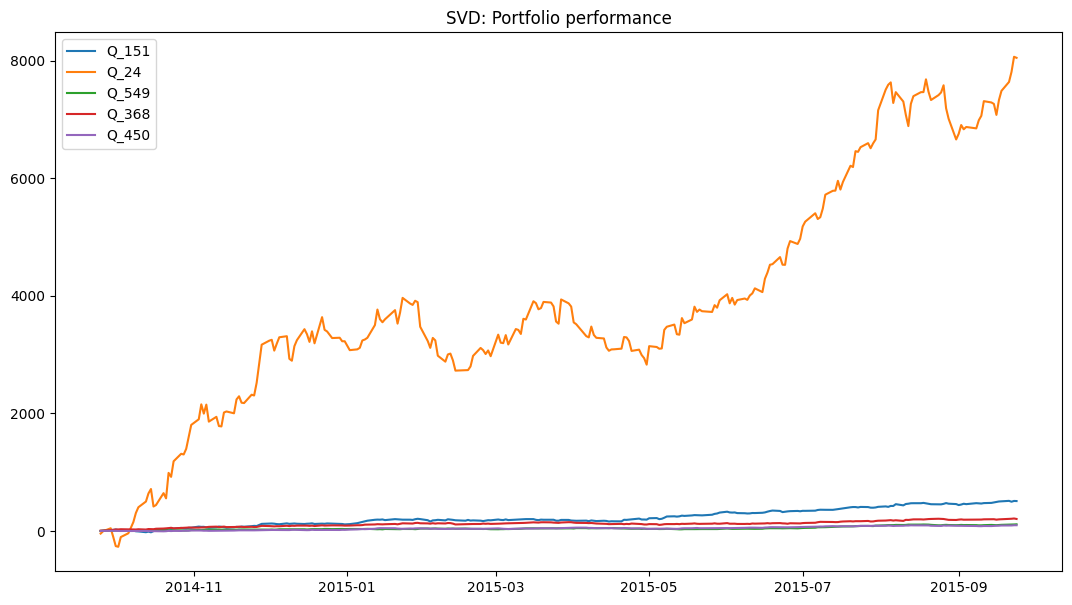

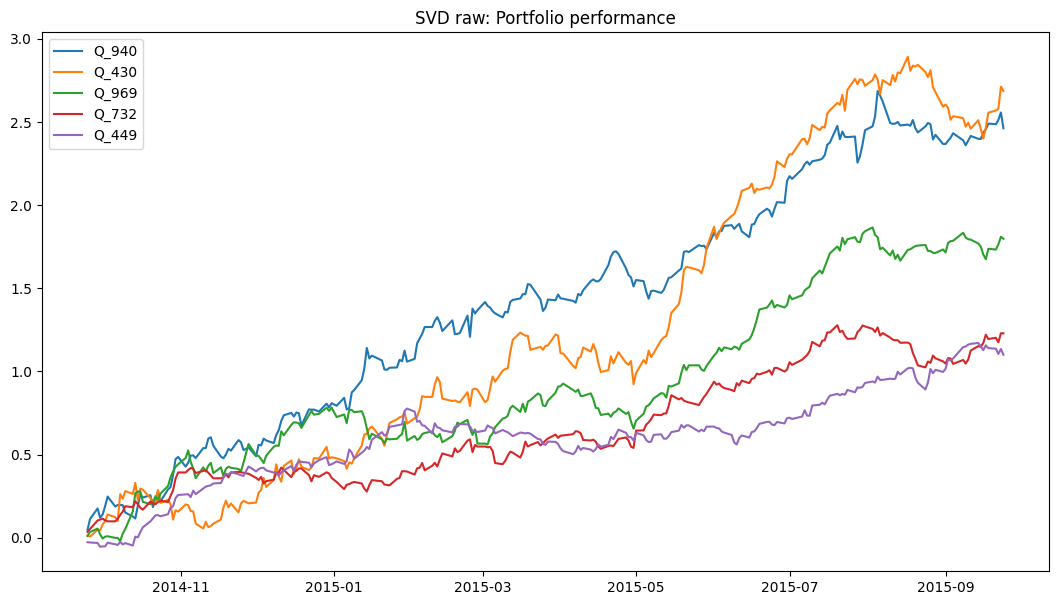

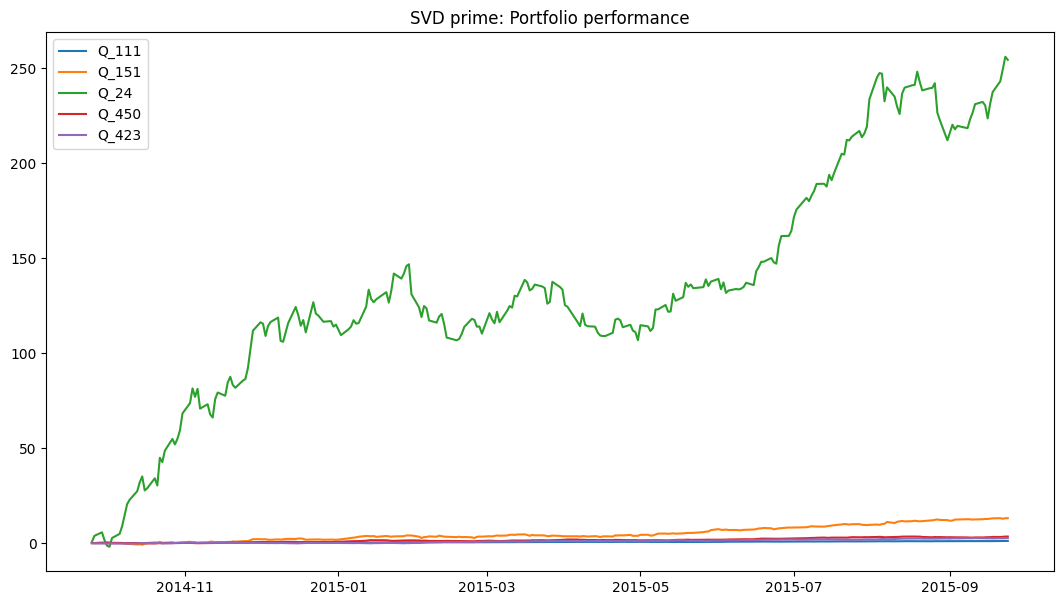

In [ ]:
plot_performance(c_svd_rets, 
                 svd_sharpe.head(5).index,
                 title='SVD')
plot_performance(c_svd_rets_raw, 
                 svd_raw_sharpe.head(5).index,
                 title='SVD raw')
plot_performance(c_svd_rets_prime, 
                 svd_prime_sharpe.head(5).index,
                 title='SVD prime')
